In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
!pip install -r /content/gdrive/MyDrive/Project/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.0 MB/s 
     |████████████████████████████████| 10.7 MB 56.3 MB/s 
     |████████████████████████████████| 76 kB 6.0 MB/s 
     |████████████████████████████████| 68 kB 9.3 MB/s 
     |████████████████████████████████| 55 kB 4.4 MB/s 
     |████████████████████████████████| 250 kB 75.5 MB/s 
     |████████████████████████████████| 5.8 MB 74.2 MB/s 
     |████████████████████████████████| 451 kB 64.7 MB/s 
  Using cached pybind11-2.10.1-py3-none-any.whl (216 kB)
     |████████████████████████████████| 8.2 MB 67.2 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 9.2 MB 65.5 MB/s 
     |████████████████████████████████| 1.9 MB 64.5 MB/s 
     |████████████████████████████████| 7.6 MB 55.7 MB/s 
     |████████████████████████████████| 1.3 MB 61.9 MB/s 
     |████████████████████████████████|

In [1]:
import argparse
import json
import pandas as pd
import numpy as np
from simpletransformers.classification import ClassificationModel
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
import matplotlib.pyplot as plt
import contractions
import nltk
nltk.download('stopwords')
nltk.download('punkt')
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data analysis

In [2]:
def load_input(df):
    if type(df) != pd.DataFrame:
        df = pd.read_json(df, lines=True)
    
    ret = []
    for _, i in df.iterrows():
        ret += [{'text': ' '.join(i['postText']) + ' - ' + i['targetTitle'] + ' ' + ' '.join(i['targetParagraphs']),
                 'uuid': i['uuid'],
                  'target' : i['tags'][0]}]
    
    return pd.DataFrame(ret)

def expand_words(text):
    expanded_words = []   
    for word in text:
        expanded_words.append(contractions.fix(word))  
    
    return expanded_words

In [3]:
train = load_input('/content/gdrive/MyDrive/Project/train.jsonl')
test = load_input('/content/gdrive/MyDrive/Project/validation.jsonl')

noise = stopwords.words('english') + list(punctuation) + ['«', '»', '``', '\'\'', '–', '—', '’']
train['text_tokenized'] = train['text'].str.replace('\n', ' ').str.lower().str.strip().apply(lambda x: word_tokenize(x, language='english'))
train['text_tokenized'] = train['text_tokenized'].apply(lambda x: [w for w in x if w not in noise])
train['text_tokenized'] = train['text_tokenized'].apply(lambda x: expand_words(x))
test['text_tokenized'] = test['text'].str.replace('\n', ' ').str.lower().str.strip().apply(lambda x: word_tokenize(x, language='english'))
test['text_tokenized'] = test['text_tokenized'].apply(lambda x: [w for w in x if w not in noise])
test['text_tokenized'] = test['text_tokenized'].apply(lambda x: expand_words(x))

X_train, y_train = train['text_tokenized'].apply(lambda x : ' '.join(x)).values, train['target'].values
X_test, y_test = test['text_tokenized'].apply(lambda x : ' '.join(x)).values, test['target'].values

In [ ]:
## классы несбалансированы

train['target'].value_counts()

phrase     1367
passage    1274
multi       559
Name: target, dtype: int64

In [ ]:
## Выборочно проверили на опечатки в ворде, опечаток не обнаружено :) 

In [ ]:
## найдем топ 300 слов по встречаемости во всех предложениях
top300 = train['text_tokenized'].explode().value_counts().head(300)
top20 = top300.head(20)
top300

's        11606
one        5309
said       4654
n't        4326
people     4229
          ...  
free        434
behind      433
major       431
donald      431
whole       430
Name: text_tokenized, Length: 300, dtype: int64

In [ ]:
## найдем топ 5 слов по встречаемости во всех предложениях по классам
top300 = train.groupby('target')['text_tokenized'].apply(lambda x : x.explode().value_counts().head(5))
pd.DataFrame(top300)

text_tokenized
target                        
multi   's                2542
        one               1403
        n't               1205
        people            1177
        like              1071
passage 's                4477
        one               1986
        said              1871
        inc.              1854
        like              1656
phrase  's                4587
        one               1920
        said              1915
        n't               1533
        like              1412

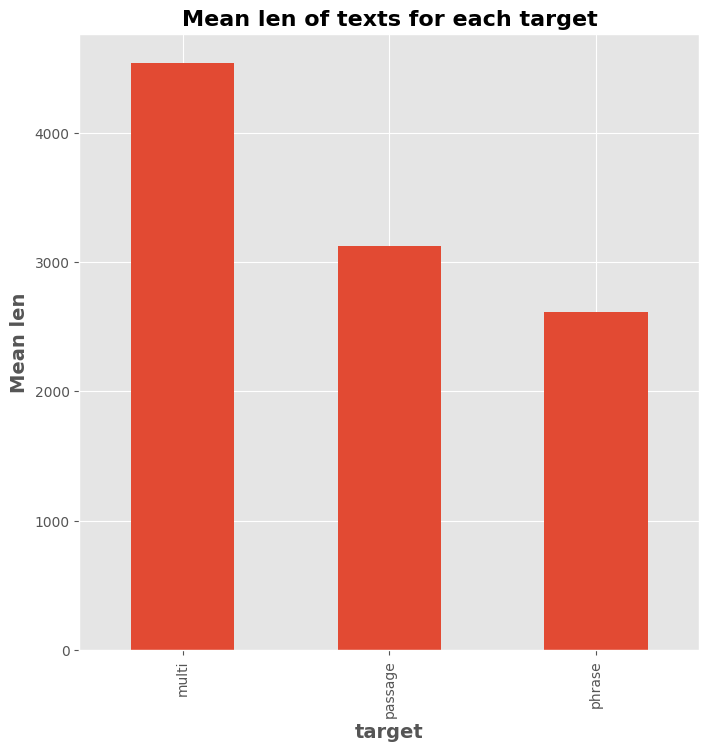

In [ ]:
import matplotlib.pyplot as plt
train['len_text'] = train['text'].str.len()

plt.style.use('ggplot')
plt.figure(figsize=(8, 8))

plt.title('Mean len of texts for each target', size=16, weight='bold')

plt.xlabel('Target', size=14, weight='bold')
plt.ylabel('Mean len', size=14, weight='bold')

train['len_text'] = train['text'].str.len()
train.groupby('target')['len_text'].mean().sort_values(ascending=False).plot.bar()

plt.show()

## Средняя длина текста ментше в фразах и больше в multi, что вполне закономерно

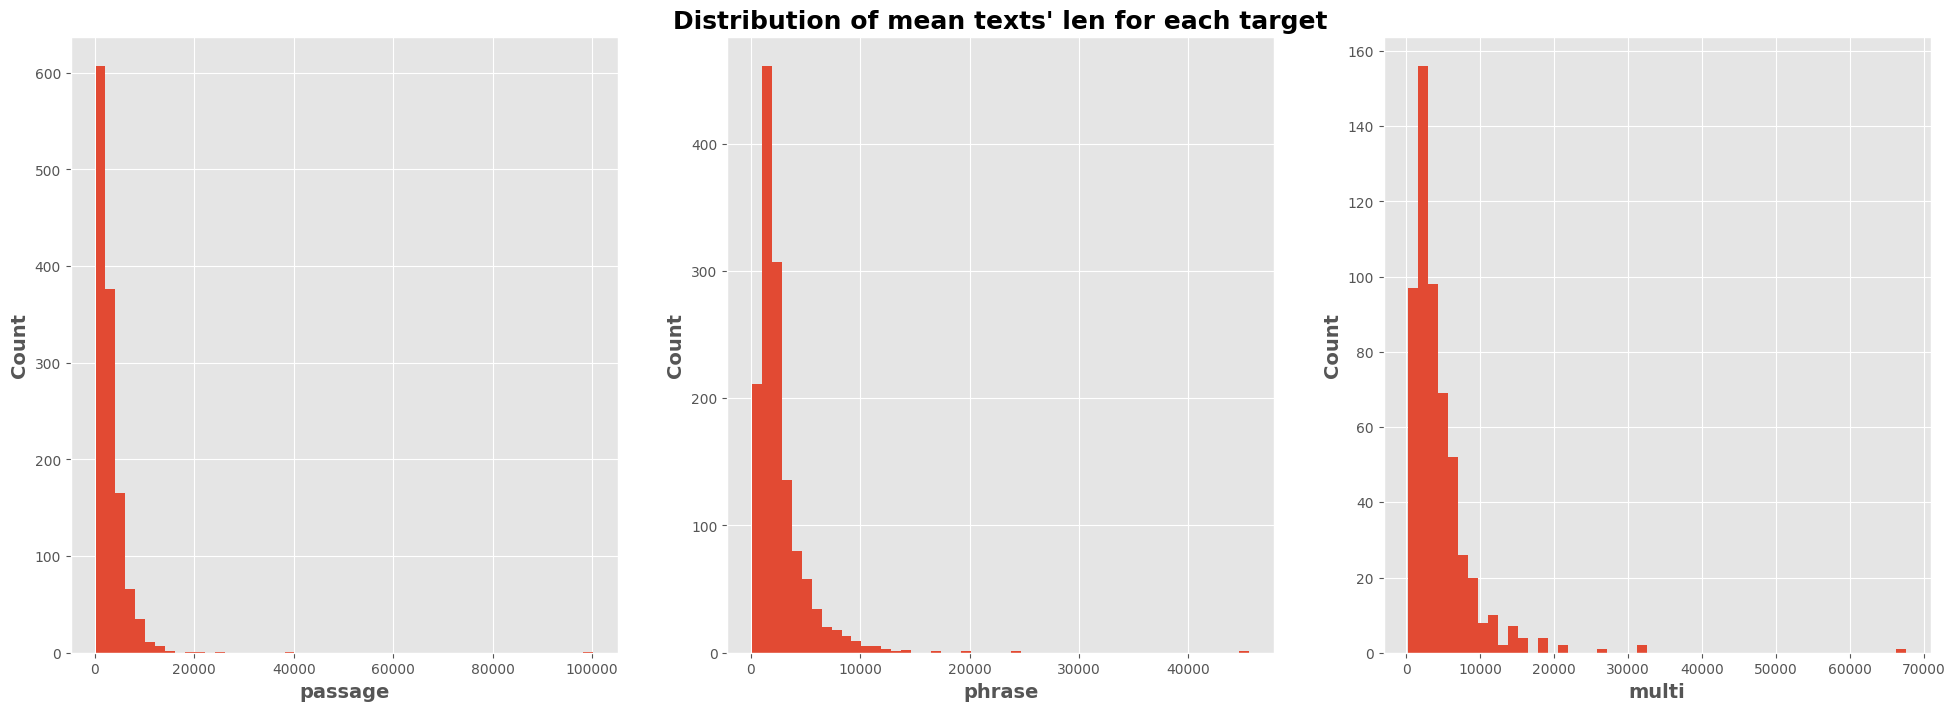

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

axs[1].set_title('Distribution of mean texts\' len for each target', size=18, weight='bold')

for i, target in enumerate(train['target'].unique()):
    train[train['target'] == target]['len_text'].plot.hist(ax=axs[i], bins=50)
    
    axs[i].set_xlabel(target, size=14, weight='bold')
    axs[i].set_ylabel('Count', size=14, weight='bold')

## Baselines

В соревновании был предоставлен код для получения двух бейзлайнов:

Baseline1 - предсказание одного класса "passage"

Baseline2 - предсказания, полученные с помощью fine-tuned трансформера

Посчитаем бейзлайны:

In [ ]:
from sklearn.metrics import f1_score

y_pred = np.full(len(y_test), 'passage')
print('Macro F1 for baseline1:', f1_score(y_test, y_pred, average='macro'))

Macro F1 for baseline1: 0.19132501485442663


In [ ]:
def use_cuda():
    return torch.cuda.is_available() and torch.cuda.device_count() > 0

def predict(df):
    df = load_input(df)
    labels = ['phrase', 'passage', 'multi']
    model = ClassificationModel('deberta', '/kaggle/input/webisclickbait/spoiler-type-classification', use_cuda=use_cuda())

    uuids = list(df['uuid'])
    texts = list(df['text'])
    predictions = model.predict(texts)[1]
    
    for i in range(len(df)):
        yield {'uuid': uuids[i], 'spoilerType': labels[np.argmax(predictions[i])]}

def run_baseline(input_file, output_file):
    predictions = []
    for prediction in predict(input_file):
        predictions.append(prediction)
    return predictions

In [ ]:
pred = run_baseline('/kaggle/input/webisclickbait/webis-clickbait-22/validation.jsonl', 'res.jsonl')
pred = list(map(lambda x : x['spoilerType'], pred))

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import f1_score

y_true = load_input('/kaggle/input/webisclickbait/webis-clickbait-22/validation.jsonl')['target']
print('Macro F1 for baseline2:' ,f1_score(y_true, pred, average='macro'))

Macro F1 for baseline2: 0.7385822029349418


## Наша модель

In [ ]:
## 5-folds CV

In [ ]:
for fold in range(5):
    with open(f'data.train_fold{fold + 1}.txt', 'w', encoding='utf-8') as outfile:
        for i in np.delete(np.arange(X_train.shape[0]), np.arange(fold * X_train.shape[0] // 5, (fold + 1) * X_train.shape[0] // 5)):
            outfile.write('__label__' + y_train[i] + ' '+ X_train[i] + '\n')

In [ ]:
import fasttext
from tqdm.notebook import tqdm

scores = []
epochs = [5, 10, 20, 30, 50]

for epoch in tqdm(epochs):
    scores.append([])
    for fold in range(5):
        classifier = fasttext.train_supervised(f'data.train_fold{fold + 1}.txt', epoch=epoch)
        y_pred = classifier.predict(X_train[fold * X_train.shape[0] // 5: (fold + 1) * X_train.shape[0] // 5].tolist())
        score = f1_score(np.array(list(map(lambda x : "__label__" + x,
                                y_train[fold * X_train.shape[0] // 5: (fold + 1) * X_train.shape[0] // 5]))),
                                np.array(y_pred[0]).squeeze(), average='macro')
        scores[-1].append(score)

  0%|          | 0/5 [00:00<?, ?it/s]

Read 0M words
Number of words:  56644
Number of labels: 3
Progress: 100.0% words/sec/thread: 5176195 lr:  0.000000 avg.loss:  1.100602 ETA:   0h 0m 0s
Read 0M words
Number of words:  60687
Number of labels: 3
Progress: 100.0% words/sec/thread: 5274725 lr:  0.000000 avg.loss:  1.099013 ETA:   0h 0m 0s
Read 0M words
Number of words:  61190
Number of labels: 3
Progress: 100.0% words/sec/thread: 4028152 lr:  0.000000 avg.loss:  1.098850 ETA:   0h 0m 0s
Read 0M words
Number of words:  60802
Number of labels: 3
Progress: 100.0% words/sec/thread: 5133986 lr:  0.000000 avg.loss:  1.099810 ETA:   0h 0m 0s
Read 0M words
Number of words:  61468
Number of labels: 3
Progress: 100.0% words/sec/thread: 5159489 lr:  0.000000 avg.loss:  1.099296 ETA:   0h 0m 0s
Read 0M words
Number of words:  56644
Number of labels: 3
Progress: 100.0% words/sec/thread: 5147142 lr:  0.000000 avg.loss:  1.062831 ETA:   0h 0m 0s
Read 0M words
Number of words:  60687
Number of labels: 3
Progress: 100.0% words/sec/thread: 4

In [ ]:
scores = np.array(scores)
scores

array([[0.20837809, 0.19521179, 0.19100706, 0.20188816, 0.20087336],
       [0.20837809, 0.19521179, 0.19100706, 0.20188816, 0.20087336],
       [0.33924742, 0.34832921, 0.30679876, 0.3435452 , 0.35240257],
       [0.49068761, 0.46627909, 0.45879365, 0.43958607, 0.48307471],
       [0.48118693, 0.45495829, 0.46358096, 0.45237287, 0.5027806 ]])

In [ ]:
scores = scores.mean(axis=1)

Text(0, 0.5, 'f1')

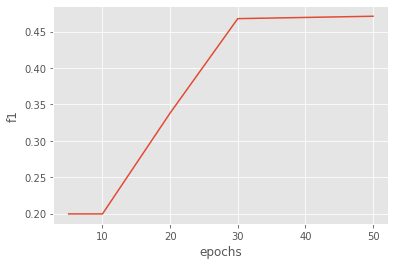

In [ ]:
plt.plot(epochs, scores)
plt.xlabel('epochs')
plt.ylabel('f1')

In [ ]:
best_epoch = 50

with open('data.train.txt', 'w', encoding='utf-8') as outfile:
    for i in range(len(X_train)):
        outfile.write('__label__' + y_train[i] + ' '+ X_train[i] + '\n')
        
classifier = fasttext.train_supervised('data.train.txt', epoch=best_epoch)

Read 0M words
Number of words:  68227
Number of labels: 3
Progress: 100.0% words/sec/thread: 4865597 lr:  0.000000 avg.loss:  0.445100 ETA:   0h 0m 0s


In [ ]:
y_pred = classifier.predict(X_test.tolist())
print('Macro F1:', f1_score(np.array(list(map(lambda x : "__label__" + x, y_test))),
                            np.array(y_pred[0]).squeeze(), average='macro'))

Macro F1: 0.46217413313852723


Наша базовая модель побила baseline1, однако далека от второго бейзлайна.

Поменяем названия колонок для обучения трансформеров, а также преобразуем целевую колонку:

In [5]:
train = train.rename(columns={"target":"label"})
test = test.rename(columns={"target":"label"})

In [ ]:
df_train = train[["text", "label"]]

In [ ]:
df_train.head(5)

,text,label
0,"Wes Welker Wanted Dinner With Tom Brady, But P...",passage
1,NASA sets date for full recovery of ozone hole...,phrase
2,This is what makes employees happy -- and it's...,phrase
3,Passion is overrated — 7 work habits you need ...,multi
4,The perfect way to cook rice so that it's perf...,phrase


In [ ]:
import numpy as np

In [ ]:
mapper = {"passage": 0, "phrase":1, "multi":2}
for item_type in mapper.keys():
  df_train[item_type] = np.where(df_train['label']== item_type, 1, 0)
df_train = df_train.drop(["label"], axis=1)

In [ ]:
df_train

,text,passage,phrase,multi
0,"Wes Welker Wanted Dinner With Tom Brady, But P...",1,0,0
1,NASA sets date for full recovery of ozone hole...,0,1,0
2,This is what makes employees happy -- and it's...,0,1,0
3,Passion is overrated — 7 work habits you need ...,0,0,1
4,The perfect way to cook rice so that it's perf...,0,1,0
...,...,...,...,...
3195,Has Facebook's video explosion completely shak...,1,0,0
3196,Cop Is Eating At A Chili's When Teen Hands Him...,1,0,0
3197,5 popular myths about visible signs of aging t...,0,0,1
3198,You need to see this Twitter account that pred...,0,1,0


In [6]:
mapper = {"passage": 0, "phrase":1, "multi":2}
train["label"] = train["label"].replace(mapper)
train_data = train[["text", "label"]]
train_data

,text,label
0,"Wes Welker Wanted Dinner With Tom Brady, But P...",0
1,NASA sets date for full recovery of ozone hole...,1
2,This is what makes employees happy -- and it's...,1
3,Passion is overrated — 7 work habits you need ...,2
4,The perfect way to cook rice so that it's perf...,1
...,...,...
3195,Has Facebook's video explosion completely shak...,0
3196,Cop Is Eating At A Chili's When Teen Hands Him...,0
3197,5 popular myths about visible signs of aging t...,2
3198,You need to see this Twitter account that pred...,1


In [7]:
test["label"] = test["label"].replace(mapper)
test_data = test[["text", "label"]]
test_data

,text,label
0,Five Nights at Freddy’s Sequel Delayed for Wei...,0
1,Why Arizona Sheriff Joe Arpaio’s fate could ha...,2
2,Here’s how much you should be tipping your hai...,1
3,"""Harry Potter"" alums reunite for new movie - A...",2
4,A man swallowed a microSD card and you won't b...,0
...,...,...
795,This is what happens when you leave a hotel cl...,0
796,This Texas GOP elector announces that he won't...,1
797,This beauty queen cured her acne with one diet...,2
798,WikiLeaks' Julian Assange Reported Dead - Wiki...,0


### Transformers training section:

обработаем данные с помощью berttokenizer

In [8]:
import torch
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification, BertTokenizer
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

def encoding_data(tokenizer, max_length=512, batch_size=4):
    encoded_data_train = tokenizer.batch_encode_plus(
        train_data["text"].values, 
        add_special_tokens=True, 
        return_attention_mask=True, 
        pad_to_max_length=True, 
        max_length=512, 
        return_tensors='pt'
    )

    encoded_data_val = tokenizer.batch_encode_plus(
        test_data["text"].values, 
        add_special_tokens=True, 
        return_attention_mask=True, 
        pad_to_max_length=True, 
        max_length=512, 
        return_tensors='pt'
    )

    input_ids_train = encoded_data_train['input_ids']
    attention_masks_train = encoded_data_train['attention_mask']
    labels_train = torch.tensor(train_data["label"].values)

    input_ids_val = encoded_data_val['input_ids']
    attention_masks_val = encoded_data_val['attention_mask']
    labels_val = torch.tensor(test_data["label"].values)

    dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

    dataloader_train = DataLoader(dataset_train, 
                                  sampler=RandomSampler(dataset_train), 
                                  batch_size=batch_size)

    dataloader_validation = DataLoader(dataset_val, 
                                      sampler=SequentialSampler(dataset_val), 
                                      batch_size=batch_size)
    return dataloader_train, dataloader_validation

In [10]:
import random
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in mapper.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [13]:
def evaluate(model, df_val, device):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []
    for batch in df_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }
        with torch.no_grad():        
            outputs = model(**inputs)
          
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(df_val) 
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    return loss_val_avg, predictions, true_vals

In [17]:
from transformers import AdamW, get_linear_schedule_with_warmup

def training(model_name, model, epochs, df_train, df_val, path_to_folder):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)
  print(f'Training session for {model_name} model:')
  optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(df_train)*epochs)
  for epoch in tqdm(range(1, epochs+1)):
      model.train()
      loss_train_total = 0
      progress_bar = tqdm(df_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
      for batch in progress_bar:
          model.zero_grad()
          batch = tuple(b.to(device) for b in batch)
          inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'labels':         batch[2],
                  }       
          outputs = model(**inputs)
          loss = outputs[0]
          loss_train_total += loss.item()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()
          scheduler.step()
          progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
          
      path_to_save = path_to_folder + "/" + model_name + "_epoch_" + str(epoch) + ".model"
      torch.save(model.state_dict(), path_to_save)
      tqdm.write(f'\nEpoch {epoch}')    
      loss_train_avg = loss_train_total/len(df_train)            
      tqdm.write(f'Training loss: {loss_train_avg}')
      val_loss, predictions, true_vals = evaluate(model, df_val, device)
      val_acc = accuracy_score_func(predictions, true_vals)
      val_f1 = f1_score_func(predictions, true_vals)
      tqdm.write(f'Validation loss: {val_loss}')
      tqdm.write(f'Accuracy Score: {val_acc}')
      tqdm.write(f'F1 Score (Weighted): {val_f1}')

### BERT training session:

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
train, val = encoding_data(tokenizer, 512, 8)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [22]:
bert_model = BertForSequenceClassification.from_pretrained("bert-base-cased",
                                                      num_labels=len(mapper),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
bert_storage = "/content/gdrive/MyDrive/Project/storage_for_BERT"
training("BERT", bert_model, 3, train, val, bert_storage)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Training session for BERT model:


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0091740119457244
Validation loss: 0.9213734322786331
Accuracy Score: 0.57
F1 Score (Weighted): 0.5657280607701761


Epoch 2:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.8579841542243958
Validation loss: 0.8078138449788094
Accuracy Score: 0.6525
F1 Score (Weighted): 0.6478189267011306


Epoch 3:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.7071177180111409
Validation loss: 0.7831260922551155
Accuracy Score: 0.64625
F1 Score (Weighted): 0.6431878707212744


In [23]:
bert_model = BertForSequenceClassification.from_pretrained("bert-base-cased",
                                                      num_labels=len(mapper),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

bert_model.to(device)

bert_model.load_state_dict(torch.load('/content/gdrive/MyDrive/Project/storage_for_BERT/BERT_epoch_3.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(bert_model, val, device)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Class: passage
Accuracy: 238/322

Class: phrase
Accuracy: 212/335

Class: multi
Accuracy: 67/143



### RoBERTa training session:

In [24]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train, val = encoding_data(tokenizer, 512, 8)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [25]:
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base",
                                                      num_labels=len(mapper),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
roberta_storage = "/content/gdrive/MyDrive/Project/storage_for_RoBERTa"
training("RoBERTa", roberta_model, 3, train, val, roberta_storage)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

Training session for RoBERTa model:


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0031937493383885
Validation loss: 0.9463445967435837
Accuracy Score: 0.55125
F1 Score (Weighted): 0.5368007794240188


Epoch 2:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.8439046135544777
Validation loss: 0.752805053293705
Accuracy Score: 0.68
F1 Score (Weighted): 0.678904912640066


Epoch 3:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.6815629687532783
Validation loss: 0.7271754030883312
Accuracy Score: 0.71125
F1 Score (Weighted): 0.7095975746592927


In [27]:
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base",
                                                      num_labels=len(mapper),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

roberta_model.to(device)

roberta_model.load_state_dict(torch.load('/content/gdrive/MyDrive/Project/storage_for_RoBERTa/RoBERTa_epoch_3.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(roberta_model, val, device)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

Class: passage
Accuracy: 261/322

Class: phrase
Accuracy: 227/335

Class: multi
Accuracy: 81/143

